<ipython-input-2-22a8bfcb7826>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


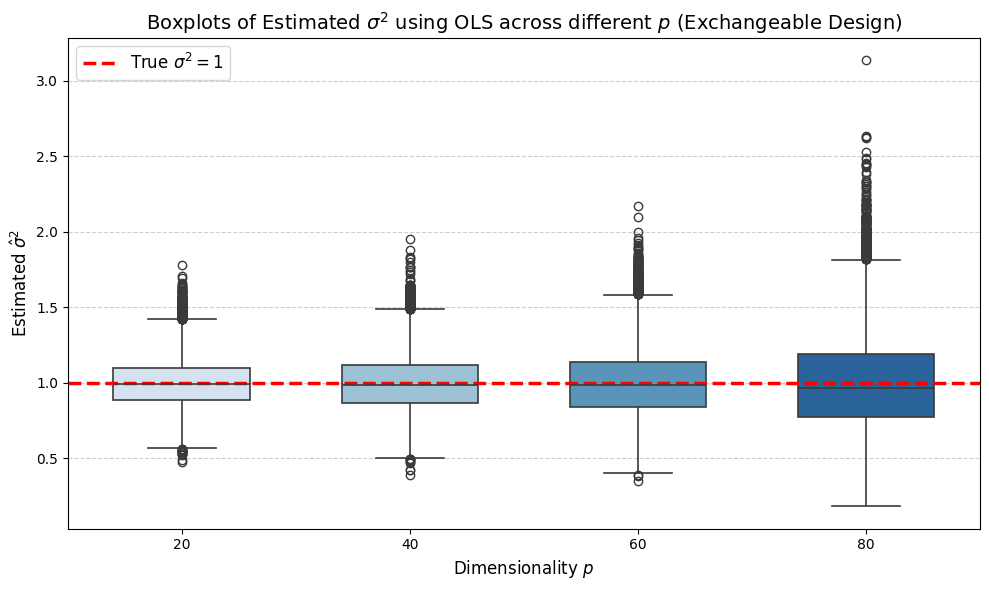

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set parameters
n = 100
B = 25000
p_values = [20, 40, 60, 80]
s = 6
sigma2_true = 1
a = 10  # parameter for exchangeable design matrix

# Storage for estimated variances
sigma2_estimates = {p: [] for p in p_values}

# Run simulation
for p in p_values:
    I_p = np.eye(p)
    E_p = np.ones((p, p))
    Gamma = I_p + a * E_p  # Exchangeable covariance matrix

    for _ in range(B):
        # Design matrix X: each row ~ N(0, Gamma)
        X = np.random.multivariate_normal(mean=np.zeros(p), cov=Gamma, size=n)

        # Construct beta
        beta = np.zeros(p)
        beta[:s] = [1, -1, 0.5, -0.5, 0.2, -0.2]

        # Response
        epsilon = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        Y = X @ beta + epsilon

        # OLS estimator of sigma^2
        if p < n:
            beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
            residuals = Y - X @ beta_hat
            sigma2_hat = np.sum(residuals**2) / (n - p)
            sigma2_estimates[p].append(sigma2_hat)

# Convert to DataFrame for visualization
df = pd.DataFrame({
    "Estimated $\hat{\sigma}^2$": np.concatenate([sigma2_estimates[p] for p in p_values]),
    "Dimensionality $p$": np.concatenate([[p]*len(sigma2_estimates[p]) for p in p_values])
})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Dimensionality $p$",
    y="Estimated $\hat{\sigma}^2$",
    data=df,
    width=0.6,
    palette="Blues",
    linewidth=1.2
)
plt.axhline(y=sigma2_true, color='red', linestyle='--', linewidth=2.5, label=r'True $\sigma^2 = 1$')
plt.title(r"Boxplots of Estimated $\sigma^2$ using OLS across different $p$ (Exchangeable Design)", fontsize=14)
plt.ylabel(r"Estimated $\hat{\sigma}^2$", fontsize=12)
plt.xlabel(r"Dimensionality $p$", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


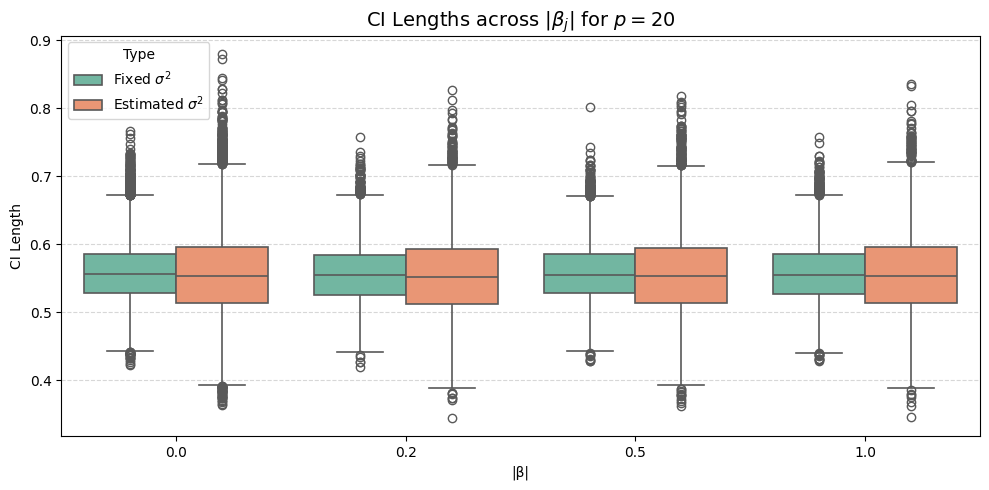

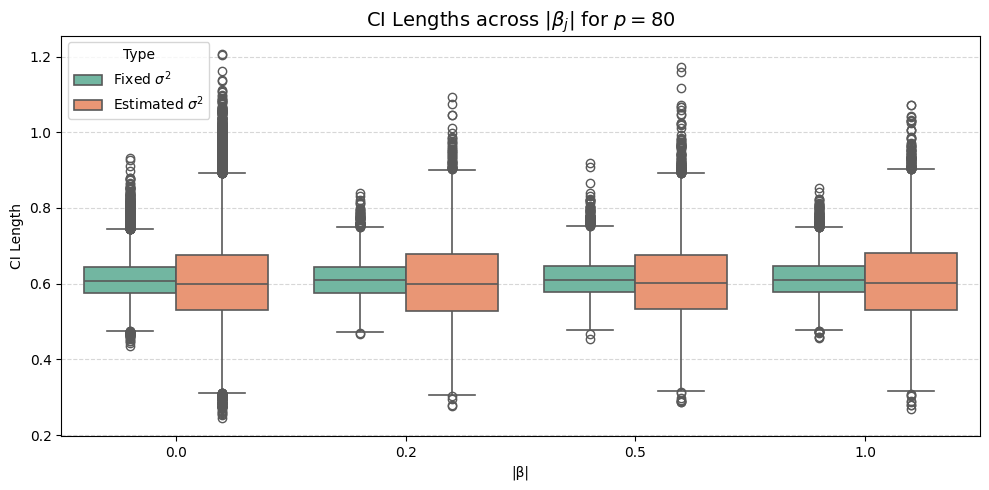

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso

n = 100
B = 25000
p_values = [20, 80]
s = 6
a = 10
sigma2_true = 1
alpha = 0.05
z_alpha = 1.96  # 95% CI

lambda_formula = lambda p, n: np.sqrt(2 * np.log(p) / n)
true_beta = np.zeros(100)  # to cover max p = 100
true_beta[:6] = [1, -1, 0.5, -0.5, 0.2, -0.2]

records = []

for p in p_values:
    beta = true_beta[:p]
    beta_abs_class = np.round(np.abs(beta), 1)

    I_p = np.eye(p)
    E_p = np.ones((p, p))
    Gamma = I_p + a * E_p

    lam = lambda_formula(p, n)

    for _ in range(B):
        X = np.random.multivariate_normal(np.zeros(p), Gamma, size=n)
        epsilon = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        Y = X @ beta + epsilon

        # Random W ~ N(0, sigma^2 I)
        W = np.random.normal(0, np.sqrt(sigma2_true), size=n)

        f = 0.5
        gamma = np.sqrt((1 - f) / f)

        U = Y + gamma * W
        V = Y - W / gamma

        # Lasso on U
        lasso = Lasso(alpha=lam/2, fit_intercept=False, max_iter=10000)
        lasso.fit(X, U)
        selected = np.where(lasso.coef_ != 0)[0]
        m = len(selected)
        if m == 0 or m >= n:
            continue

        X_sel = X[:, selected]
        XtX_inv = np.linalg.inv(X_sel.T @ X_sel)
        beta_hat = XtX_inv @ X_sel.T @ V

        # Fixed σ² CIs
        var_fixed = sigma2_true * (1 + gamma**-2)
        ci_length_fixed = 2 * z_alpha * np.sqrt(var_fixed * np.diag(XtX_inv))

        # Estimated σ² using residuals from OLS
        beta_ols = np.linalg.pinv(X) @ Y
        residual = Y - X @ beta_ols
        sigma2_hat = np.sum(residual**2) / (n - p)
        var_est = sigma2_hat * (1 + gamma**-2)
        ci_length_est = 2 * z_alpha * np.sqrt(var_est * np.diag(XtX_inv))

        for j, idx in enumerate(selected):
            abs_val = round(np.abs(beta[idx]), 1)
            records.append({
                "CI Length": ci_length_fixed[j],
                "Type": "Fixed $\sigma^2$",
                "|β|": abs_val,
                "p": p
            })
            records.append({
                "CI Length": ci_length_est[j],
                "Type": "Estimated $\sigma^2$",
                "|β|": abs_val,
                "p": p
            })

# Plot
df_ci = pd.DataFrame(records)
for p in p_values:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_ci[df_ci["p"] == p],
                x="|β|", y="CI Length", hue="Type", palette="Set2", linewidth=1.2)
    plt.title(f"CI Lengths across $|\\beta_j|$ for $p = {p}$", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


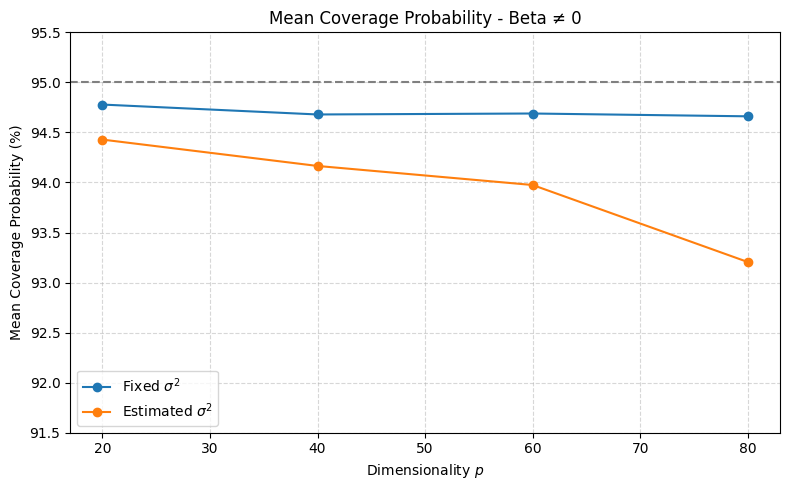

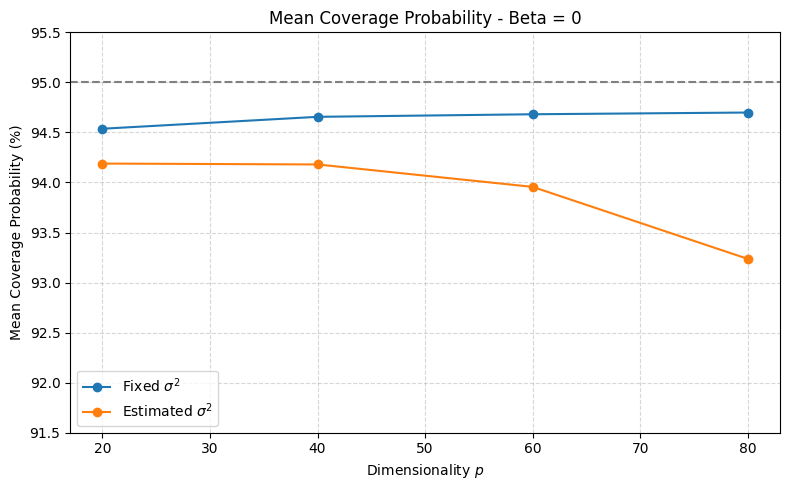

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

# Parameters
n = 100
B = 25000
p_list = [20, 40, 60, 80]
s = 6
a = 10
sigma2_true = 1
alpha = 0.05
z_alpha = 1.96

lambda_formula = lambda p, n: np.sqrt(2 * np.log(p) / n)
true_beta = np.zeros(100)
true_beta[:6] = [1, -1, 0.5, -0.5, 0.2, -0.2]

results = []

for p in p_list:
    beta = true_beta[:p]
    active_idx = np.where(beta != 0)[0]
    null_idx = np.where(beta == 0)[0]

    cov_count_fixed = {"active": 0, "null": 0}
    cov_count_est = {"active": 0, "null": 0}
    total_active = 0
    total_null = 0

    I_p = np.eye(p)
    E_p = np.ones((p, p))
    Gamma = I_p + a * E_p

    lam = lambda_formula(p, n)
    for _ in range(B):
        X = np.random.multivariate_normal(np.zeros(p), Gamma, size=n)
        epsilon = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        Y = X @ beta + epsilon

        W = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        f = 0.5
        gamma = np.sqrt((1 - f) / f)
        U = Y + gamma * W
        V = Y - W / gamma

        lasso = Lasso(alpha=lam/2, fit_intercept=False, max_iter=10000)
        lasso.fit(X, U)
        selected = np.where(lasso.coef_ != 0)[0]
        if len(selected) == 0 or len(selected) >= n:
            continue

        X_sel = X[:, selected]
        XtX_inv = np.linalg.inv(X_sel.T @ X_sel)
        beta_hat = XtX_inv @ X_sel.T @ V

        var_fixed = sigma2_true * (1 + gamma**-2)
        ci_radius_fixed = z_alpha * np.sqrt(var_fixed * np.diag(XtX_inv))

        beta_ols = np.linalg.pinv(X) @ Y
        residual = Y - X @ beta_ols
        sigma2_hat = np.sum(residual**2) / (n - p)
        var_est = sigma2_hat * (1 + gamma**-2)
        ci_radius_est = z_alpha * np.sqrt(var_est * np.diag(XtX_inv))

        for j, idx in enumerate(selected):
            true_val = beta[idx]
            low1, high1 = beta_hat[j] - ci_radius_fixed[j], beta_hat[j] + ci_radius_fixed[j]
            low2, high2 = beta_hat[j] - ci_radius_est[j], beta_hat[j] + ci_radius_est[j]
            if idx in active_idx:
                total_active += 1
                cov_count_fixed["active"] += int(low1 <= true_val <= high1)
                cov_count_est["active"] += int(low2 <= true_val <= high2)
            elif idx in null_idx:
                total_null += 1
                cov_count_fixed["null"] += int(low1 <= 0 <= high1)
                cov_count_est["null"] += int(low2 <= 0 <= high2)

    for group in ["active", "null"]:
        total = total_active if group == "active" else total_null
        if total > 0:
            results.append({
                "p": p,
                "Group": "Beta ≠ 0" if group == "active" else "Beta = 0",
                "Type": "Fixed $\sigma^2$",
                "Coverage": 100 * cov_count_fixed[group] / total
            })
            results.append({
                "p": p,
                "Group": "Beta ≠ 0" if group == "active" else "Beta = 0",
                "Type": "Estimated $\sigma^2$",
                "Coverage": 100 * cov_count_est[group] / total
            })

df_cov = pd.DataFrame(results)

# Plot line chart
for group in ["Beta ≠ 0", "Beta = 0"]:
    df_sub = df_cov[df_cov["Group"] == group]
    plt.figure(figsize=(8, 5))
    for t in ["Fixed $\sigma^2$", "Estimated $\sigma^2$"]:
        subset = df_sub[df_sub["Type"] == t]
        plt.plot(subset["p"], subset["Coverage"], marker='o', label=t)

    plt.title(f"Mean Coverage Probability - {group}")
    plt.ylabel("Mean Coverage Probability (%)")
    plt.xlabel("Dimensionality $p$")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.ylim(91.5, 95.5)
    plt.axhline(y=95, linestyle="--", color="gray")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso

# Parameters
n = 100
B = 25000
p_values = [20, 40, 60, 80]
s = 6
a = 10
sigma2_true = 1
z_alpha = 1.96
lambda_formula = lambda p, n: np.sqrt(2 * np.log(p) / n)

true_beta = np.zeros(100)
true_beta[:6] = [1, -1, 0.5, -0.5, 0.2, -0.2]

summary_data = []

for p in p_values:
    beta = true_beta[:p]
    I_p = np.eye(p)
    E_p = np.ones((p, p))
    Gamma = I_p + a * E_p
    lam = lambda_formula(p, n)

    fixed_group = {v: [] for v in [0.0, 0.2, 0.5, 1.0]}
    est_group = {v: [] for v in [0.0, 0.2, 0.5, 1.0]}

    for _ in range(B):
        X = np.random.multivariate_normal(np.zeros(p), Gamma, size=n)
        epsilon = np.random.normal(0, np.sqrt(sigma2_true), size=n)
        Y = X @ beta + epsilon
        W = np.random.normal(0, np.sqrt(sigma2_true), size=n)

        f = 0.5
        gamma = np.sqrt((1 - f) / f)
        U = Y + gamma * W
        V = Y - W / gamma

        lasso = Lasso(alpha=lam/2, fit_intercept=False, max_iter=10000)
        lasso.fit(X, U)
        selected = np.where(lasso.coef_ != 0)[0]
        if len(selected) == 0 or len(selected) >= n:
            continue

        X_sel = X[:, selected]
        XtX_inv = np.linalg.inv(X_sel.T @ X_sel)
        var_fixed = sigma2_true * (1 + gamma**-2)
        ci_fixed = 2 * z_alpha * np.sqrt(var_fixed * np.diag(XtX_inv))

        beta_ols = np.linalg.pinv(X) @ Y
        sigma2_hat = np.sum((Y - X @ beta_ols)**2) / (n - p)
        var_est = sigma2_hat * (1 + gamma**-2)
        ci_est = 2 * z_alpha * np.sqrt(var_est * np.diag(XtX_inv))

        for j, idx in enumerate(selected):
            b_val = round(np.abs(beta[idx]), 1)
            if b_val in fixed_group:
                fixed_group[b_val].append(ci_fixed[j])
                est_group[b_val].append(ci_est[j])

    for b in [0.0, 0.2, 0.5, 1.0]:
        median_est = np.median(est_group[b])
        std_est = np.std(est_group[b])
        median_fix = np.median(fixed_group[b])
        std_fix = np.std(fixed_group[b])
        summary_data.append([b, p, f"{median_est:.2f} ({std_est:.2f})", f"{median_fix:.2f} ({std_fix:.2f})"])

# 构造 DataFrame
df_summary = pd.DataFrame(summary_data, columns=["|β|", "p", "σ²_hat", "σ²_true"])
df_table = df_summary.pivot(index="|β|", columns="p", values=["σ²_hat", "σ²_true"])
print(df_table)


          σ²_hat                                             σ²_true  \
p             20           40           60           80           20   
|β|                                                                    
0.0  0.55 (0.06)  0.58 (0.07)  0.59 (0.08)  0.60 (0.11)  0.56 (0.04)   
0.2  0.55 (0.06)  0.58 (0.07)  0.59 (0.08)  0.60 (0.11)  0.55 (0.04)   
0.5  0.55 (0.06)  0.58 (0.07)  0.59 (0.08)  0.60 (0.11)  0.56 (0.04)   
1.0  0.55 (0.06)  0.58 (0.07)  0.59 (0.08)  0.60 (0.11)  0.56 (0.04)   

                                            
p             40           60           80  
|β|                                         
0.0  0.58 (0.05)  0.60 (0.05)  0.61 (0.05)  
0.2  0.58 (0.05)  0.59 (0.05)  0.61 (0.05)  
0.5  0.58 (0.05)  0.60 (0.05)  0.61 (0.05)  
1.0  0.58 (0.05)  0.60 (0.05)  0.61 (0.05)  
